Inicialmente importamos la librería que utilizaremos:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

Este notebook se dividirá en dos partes:
- Simulación de datos
- Gráfico de la misclassification curves (Figure 2.4)

## Simulación de datos:

AC: Para esta simulación reutilizaré los códigos de los notebooks anteriores. Aquí se usarán dos SETs de datos (SET_training y SET_test), los cuales tendrán un tamaño de 200 y 10000 respectivamente.

### Training Sample

In [2]:
def centros_asociados_a_cada_color(color, kcentros):
   
    centro = np.array([0,0])
    covarianza = np.identity(2)
    
    if color == 0: #azul
        centro = np.array([1,0])
    
    if color == 1: #rojo
        centro = np.array([0,1])

    lista_de_centros = np.random.multivariate_normal(centro,covarianza,kcentros).T
        
    return lista_de_centros

In [3]:
centros_azul = centros_asociados_a_cada_color(0,10)
centros_rojo = centros_asociados_a_cada_color(1,10)

In [4]:
def visualize_colors(ptos_azul, ptos_rojo):

    x1azul = ptos_azul[0]
    x2azul = ptos_azul[1]
    
    x1rojo = ptos_rojo[0]
    x2rojo = ptos_rojo[1]
    
    plt.plot(x1azul,x2azul,"bo")
    plt.plot(x1rojo,x2rojo,"ro")
    plt.axis([-4,4,-4,4])
    plt.title("Distribucion de puntos segun el color")
    plt.show() 

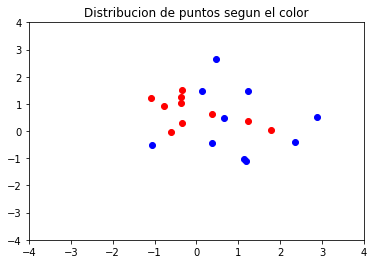

In [5]:
visualize_colors(centros_azul, centros_rojo)

In [6]:
def Simulacion_2(centros, N):
    
    Ncentros = centros.shape[1]
    
    #Initialize the list of observations 
    observations = np.zeros((2,N))
    
    #we first define the global value of the covariance
    covarianza = np.identity(2)/5
       
    #hacemos un loop entre 0 y N-1 para generar todos las observaciones requeridas
    
    for obs in range(0,N):
        #generamos un numero aleatorio entre 0 y 9 para escoger el centro de nuestra gaussiana bivariada
        indice_del_centro = random.randint(0, Ncentros-1)
        
        xcentro = centros[0,indice_del_centro]
        ycentro = centros[1,indice_del_centro]
        
        mk_centro = np.array([xcentro, ycentro])
        
        centro_aux = np.random.multivariate_normal(mk_centro,covarianza,1).T
    
        observations[0,obs] = centro_aux[0,0]
        observations[1,obs] = centro_aux[1,0]
    
    return observations

In [7]:
ptos_observados_azul_training =  Simulacion_2(centros_azul, 100)
ptos_observados_rojo_training =  Simulacion_2(centros_rojo, 100)

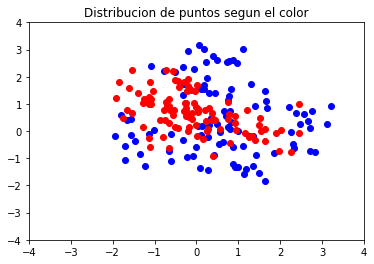

In [8]:
visualize_colors(ptos_observados_azul_training, ptos_observados_rojo_training)

### Test Sample
AC: Ahora generaré 5000 puntos para cada color (en total serán 10000 puntos) a partir de los mismos 20 centros usados para la training sample. 

In [9]:
ptos_observados_azul_test =  Simulacion_2(centros_azul, 5000)
ptos_observados_rojo_test =  Simulacion_2(centros_rojo, 5000)

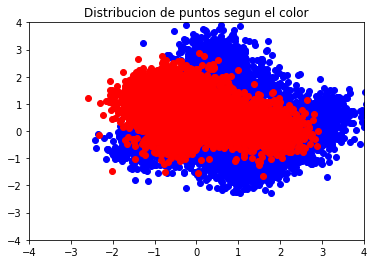

In [10]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

AC: ahora con estos puntos puedo generar los dos SETs que utilizaré

In [11]:
SET_training=[]
SET_test=[]

#PRIMERO FORMAMOS EL SET_training
x1azul_training = ptos_observados_azul_training[0,:]
x2azul_training = ptos_observados_azul_training[1,:]

x1rojo_training = ptos_observados_rojo_training[0,:]
x2rojo_training = ptos_observados_rojo_training[1,:]

#Agregamos los correspondientes a y=0 (distribución normal azul)
for i in range(len(x1azul_training)):
    SET_training.append([1,x1azul_training[i],x2azul_training[i],0])

#Ahora agregamos los correspondientes a y=1 (distribución normal roja)
for i in range(len(x1rojo_training)):
    SET_training.append([1,x1rojo_training[i],x2rojo_training[i],1])

In [12]:
#AHORA FORMAMOS EL SET_test
x1azul_test = ptos_observados_azul_test[0,:]
x2azul_test = ptos_observados_azul_test[1,:]

x1rojo_test = ptos_observados_rojo_test[0,:]
x2rojo_test = ptos_observados_rojo_test[1,:]

for i in range(len(x1azul_test)):
    SET_test.append([1,x1azul_test[i],x2azul_test[i],0])

#Ahora agregamos los correspondientes a y=1 (distribución normal roja)
for i in range(len(x1rojo_test)):
    SET_test.append([1,x1rojo_test[i],x2rojo_test[i],1])

Veamos si están bien hechos estos SETs:

In [13]:
#Comenzamos con el SET_training
ptos_observados_azul_training[:,0]

array([1.63854692, 1.47039823])

In [14]:
SET_training[0]

[1, 1.6385469211089627, 1.4703982254871242, 0]

In [15]:
ptos_observados_rojo_training[:,-1]

array([0.77837804, 0.64578416])

In [16]:
SET_training[-1]

[1, 0.7783780359034866, 0.6457841565545337, 1]

In [17]:
#Ahora veamos el SET_test
ptos_observados_azul_test[:,0]

array([ 1.46741089, -0.77156434])

In [18]:
SET_test[0]

[1, 1.4674108896962212, -0.7715643438185793, 0]

In [19]:
ptos_observados_rojo_test[:,-1]

array([ 1.74010188, -0.37588259])

In [20]:
SET_test[-1]

[1, 1.7401018818965117, -0.37588259010709313, 1]

In [21]:
len(SET_training)

200

In [22]:
len(SET_test)

10000

## Misclassification Curves:

### MÉTRICA RSS()
AC: Comenzaremos evaluando la regresión lineal con la métrica RSS(), para lo cual necesitamos los dos SETs creados anteriormente y un vector beta que minimice la función RSS(). Iniciaré calculado el beta_teórico con SET_training 

In [23]:
X=[]

for i in range(len(SET_training)):  #pondremos SET[i][1] y SET[i][2] en las componentes x1 y x2 de X
    X.append([1,SET_training[i][1],SET_training[i][2]])

Y=[]
for i in range(len(SET_training)): #Aquí Y = SET[i][3]
    Y.append(SET_training[i][3])
    
X=np.array(X)                     
Y=np.array(Y)

XT=X.transpose()

In [24]:
print(X.shape, Y.shape, XT.shape)

(200, 3) (200,) (3, 200)


In [25]:
XTdotX = np.dot(XT,X)
XTdotX

array([[200.        ,  52.18054664, 108.37160053],
       [ 52.18054664, 280.62965302, -23.98673633],
       [108.37160053, -23.98673633, 280.78806463]])

In [26]:
XTdotX_inversa = np.linalg.inv(XTdotX)
XTdotX_inversa

array([[ 0.00691449, -0.00152493, -0.00279895],
       [-0.00152493,  0.00392593,  0.00092393],
       [-0.00279895,  0.00092393,  0.0047206 ]])

In [27]:
XTdotX_inversa_dotXT = np.dot(XTdotX_inversa, XT)

In [28]:
beta_teorico = np.dot(XTdotX_inversa_dotXT,Y)
print(beta_teorico)

[ 0.51447042 -0.1147068   0.02852574]


Ahora con este beta_teorico podemos visualizar como funciona nuestro modelo de prediccion (el de regresión lineal) para estos 10000 puntos, para lo cual necesitaré primero crear la función funcion_lineal()

In [29]:
def funcion_lineal(x1, x2, beta): 
    
    y_prediccion = beta[0] + x1*beta[1] + x2*beta[2]
    return y_prediccion 

In [30]:
lista_de_predicciones_azul = []
lista_de_predicciones_rojo = []

for pto in range(len(SET_test)):
    prediccion = funcion_lineal(SET_test[pto][1], SET_test[pto][2], beta_teorico)

    #Utilizando el valor de la prediccion separamos entre puntos azules y rojos
    
    if (prediccion < 0.5):
        lista_de_predicciones_azul.append([SET_test[pto][1], SET_test[pto][2]])
    else:
        lista_de_predicciones_rojo.append([SET_test[pto][1], SET_test[pto][2]])

Ahora queremos visualizar el modelo 

In [31]:
lista_de_predicciones_azul = np.array(lista_de_predicciones_azul)
lista_de_predicciones_azul_t = lista_de_predicciones_azul.transpose()

In [32]:
print(lista_de_predicciones_azul_t.shape, lista_de_predicciones_azul.shape)

(2, 4895) (4895, 2)


In [33]:
lista_de_predicciones_rojo = np.array(lista_de_predicciones_rojo)
lista_de_predicciones_rojo_t = lista_de_predicciones_rojo.transpose()
lista_de_predicciones_rojo_t.shape

(2, 5105)

Con esto podemos comparar visualmente el sample de entrenamiento con el sample de predicciones

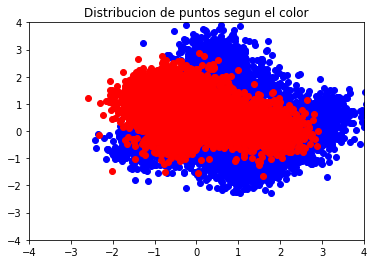

In [34]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

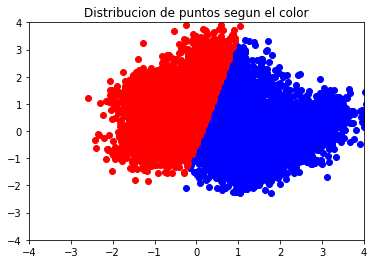

In [35]:
visualize_colors(lista_de_predicciones_azul_t, lista_de_predicciones_rojo_t)

AC: ahora que tengo el valor de beta_teorico, el cual fue obtenido del set de entrenamiento, lo utilizaré en la función RSS().

In [36]:
 def RSS(SET,beta):                    #set, en nuestro caso, tendrá dimensiones de 200 x 4 y de 10000 x 4
    SUM=0                           
    for i in range(len(SET)):
        SUM= SUM + ( SET[i][3] - funcion_lineal(SET[i][1], SET[i][2], beta))**2 
    return SUM

In [37]:
RSS( SET_training,beta_teorico)

45.96399592137877

In [38]:
RSS(SET_test,beta_teorico)

2098.703039349041

### Accuracy metric 
Para llevar a cabo esta métrica, hay que definir el número de predicciones correctas y el número total de predicciones

AC: para determinar el número de predicciones correctas se me ocurrió lo siguiente

In [55]:
predicciones_correctas=[]
predicciones_incorrectas=[]
for i in range(len(SET_test)):
     if SET_test[i][]

SyntaxError: unexpected EOF while parsing (<ipython-input-55-afa8a0a055fd>, line 4)

In [56]:
#CONTINUARÁ...